In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import matplotlib.pyplot as plt
from transformers import *
%matplotlib inline

In [2]:
MODEL_CLASSES = {
    'albert': (         AlbertForSequenceClassification,        AlbertTokenizer,        'albert-large-v2'),
    'bart': (           BartForSequenceClassification,          BartTokenizer,          'bart-large'),
    'bert': (           BertForSequenceClassification,          BertTokenizer,          'bert-base-uncased'),
    'camembert': (      CamembertForSequenceClassification,     CamembertTokenizer,     'camembert-base'),
    'distilbert': (     DistilBertForSequenceClassification,    DistilBertTokenizer,    'distilbert-base-uncased'),
    'flaubert': (       FlaubertForSequenceClassification,      FlaubertTokenizer,      'flaubert-base-uncased'),
    'roberta': (        RobertaForSequenceClassification,       RobertaTokenizer,       'roberta-base'),
    'xlm': (            XLMForSequenceClassification,           XLMTokenizer,           'xlm-mlm-en-2048'),
    'xlm_roberta':(     XLMRobertaForSequenceClassification,    XLMRobertaTokenizer,    'xlm-roberta-base'),
    'xlnet': (          XLNetForSequenceClassification,         XLNetTokenizer,         'xlnet-base-cased')
}

model_class, tokenizer, pretrained_model = MODEL_CLASSES['bert']
tokenizer = tokenizer.from_pretrained(pretrained_model)

## Tokenizer exploration

In [3]:
def token_exploration (x, add_special_tokens=False):
    tok = tokenizer.encode(x, add_special_tokens=add_special_tokens)
    print(x, "  ", tokenizer.tokenize(x), "  ", tok, ",  mida:", len(tok))
    return tok
token_exploration("Here I am", add_special_tokens=True)
token_exploration("Here I am")
token_exploration("Greetings I am")
token_exploration("Hola")
token_exploration("Moi")
token_exploration("ester")
token_exploration("esterno")
token_exploration("esternocli")
token_exploration("esternoclido")
token_exploration("esternoclidomas")
token_exploration("esternoclidomastoidal")
token_exploration("esternoclidomastoidalewq")
token_exploration("create")
token_exploration("created")
token_exploration("create d")
token_exploration("mas")
token_exploration("más")
token_exploration("másede")
token_exploration("ede")
token_exploration("masto")
token_exploration("mastodont")
token_exploration("mastodonts")
token_exploration("mastodonte")
token_exploration("mastodontes")
token_exploration("specialise")
token_exploration("specialize")
token_exploration("length")
token_exploration("lenght")
token_exploration(".")
token_exploration("més.mes")
token_exploration("un")
token_exploration("do")
token_exploration("undo")
token_exploration("[CLS]")
token_exploration("[SEP]")
token_exploration("[PAD]")

Here I am    ['here', 'i', 'am']    [101, 2182, 1045, 2572, 102] ,  mida: 5
Here I am    ['here', 'i', 'am']    [2182, 1045, 2572] ,  mida: 3
Greetings I am    ['greeting', '##s', 'i', 'am']    [14806, 2015, 1045, 2572] ,  mida: 4
Hola    ['ho', '##la']    [7570, 2721] ,  mida: 2
Moi    ['moi']    [25175] ,  mida: 1
ester    ['este', '##r']    [28517, 2099] ,  mida: 2
esterno    ['este', '##rno']    [28517, 19139] ,  mida: 2
esternocli    ['este', '##rno', '##cl', '##i']    [28517, 19139, 20464, 2072] ,  mida: 4
esternoclido    ['este', '##rno', '##cl', '##ido']    [28517, 19139, 20464, 13820] ,  mida: 4
esternoclidomas    ['este', '##rno', '##cl', '##ido', '##mas']    [28517, 19139, 20464, 13820, 9335] ,  mida: 5
esternoclidomastoidal    ['este', '##rno', '##cl', '##ido', '##mas', '##to', '##idal']    [28517, 19139, 20464, 13820, 9335, 3406, 16975] ,  mida: 7
esternoclidomastoidalewq    ['este', '##rno', '##cl', '##ido', '##mas', '##to', '##idal', '##ew', '##q']    [28517, 19139, 2046

[0]

Some conclusions:
* The end of the sequence is not marked
* Signs have an embedding
* If we pick a word and add some letters (and the new word makes no sense), the embedding will be lengthened. The original part will remain the same. The new part is not the same as if it is studied alone
* Accents are not taken into consideration
* It does not correct errors and words such as "specialise" and "specialize" are embedded differently

In [4]:
# Data Information
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
# Train Dataset

# id: rowID
# qid{1, 2}: unique ID of each question in the pair
# question{1, 2}: textual contents of the questions.
# is_duplicate: target, whether the two questions are duplicates of each other.

#df_train = pd.read_csv("../input/quora-question-pairs/train.csv.zip").fillna("")
df_train = pd.read_csv("data/train.csv").fillna("")
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
n_train = len(df_train)
print('Total of question pairs for training: {}'.format(n_train))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))

Total of question pairs for training: 404290
Duplicate pairs: 36.92%


In [7]:
tr_qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
qs_tr = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)

In [8]:
unique_dic = tr_qids.value_counts()
len(unique_dic)

537933

## **Question study**

https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb


### **Unique questions:**

Text(0, 0.5, 'Number of questions')

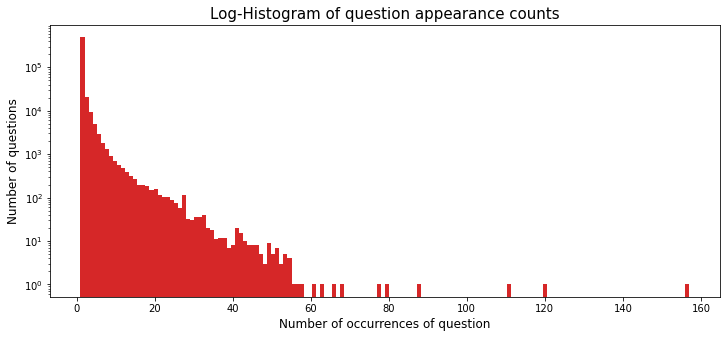

In [9]:
plt.figure(figsize=(12, 5))
plt.hist(unique_dic, bins=150, color= 'tab:red')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts', fontsize=15)
plt.xlabel('Number of occurrences of question', fontsize=12)
plt.ylabel('Number of questions', fontsize=12)

In [10]:
sorted(unique_dic, reverse=True)[0]

157

In [11]:
print("Number of unique questions: ", len(unique_dic), ".  Number of questions: ", len(tr_qids), ".  Ratio: ", 100*len(unique_dic)/len(tr_qids), '%', sep="")

Number of unique questions: 537933.  Number of questions: 808580.  Ratio: 66.52811100942392%


### **Question equivalence:**

In [12]:
node_to_class = {}
class_to_nodes = {}

def new_nodes(f,s):
    if f not in node_to_class:
        node_to_class[f] = f
        class_to_nodes[f] = [f]

    if s not in node_to_class:
        node_to_class[s] = s
        class_to_nodes[s] = [s]

def class_join(f,s):
    class_m = min(node_to_class[f], node_to_class[s])
    class_M = max(node_to_class[f], node_to_class[s])
    
    class_to_nodes[class_m] += class_to_nodes[class_M]
    for node in class_to_nodes[class_M]:
        node_to_class[node] = class_m
    del class_to_nodes[class_M]

def clusters (llista):
    '''
    input: id1, id2, t (target)
    output: it builds class_to_nodes (dictionary class:[nodes]) and nodes_to_class (dictionary node:class)
    '''
    for f,s,t in llista:
        new_nodes(f,s)
        if t and node_to_class[f] != node_to_class[s]:
            class_join(f,s)

    return (class_to_nodes, node_to_class)

In [13]:
(class_to_nodes, node_to_class) = clusters(np.array(df_train[["qid1", "qid2","is_duplicate"]]))
print("There are", len(class_to_nodes), "different question classes")

There are 448743 different question classes


In [14]:
sizes = [0]*110
for cl in class_to_nodes:
    sizes[len(class_to_nodes[cl])] += 1
assert np.sum(sizes) == len(class_to_nodes)

suma = 0
for i in range(len(sizes)):
    suma += i*sizes[i]
assert suma == len(unique_dic)

Text(0.5, 1.0, 'Log-histogram of question class size')

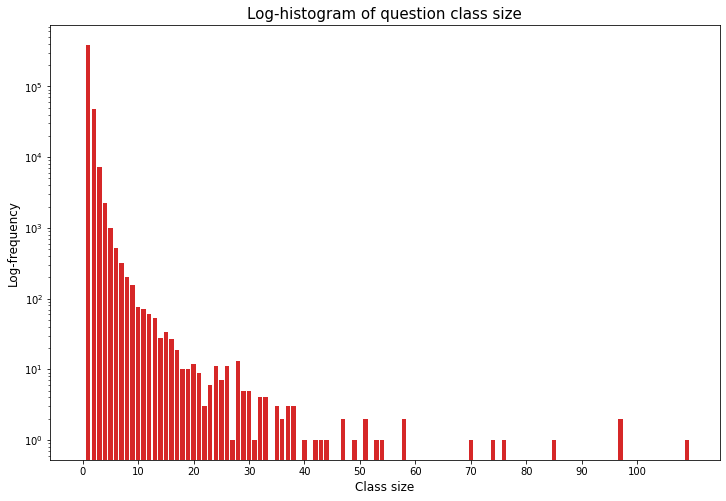

In [15]:
plt.figure(figsize=(12, 8))
plt.bar(range(len(sizes)), sizes, color="tab:red")
plt.yscale("log")
plt.xticks(range(0,len(sizes),10))
plt.xlabel("Class size", fontsize=12)
plt.ylabel("Log-frequency", fontsize=12)
plt.title("Log-histogram of question class size", fontsize=15)

### **Sentence length:**

https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb

In [30]:
cc_train = qs_tr.apply(len)

Text(0, 0.5, 'Probability')

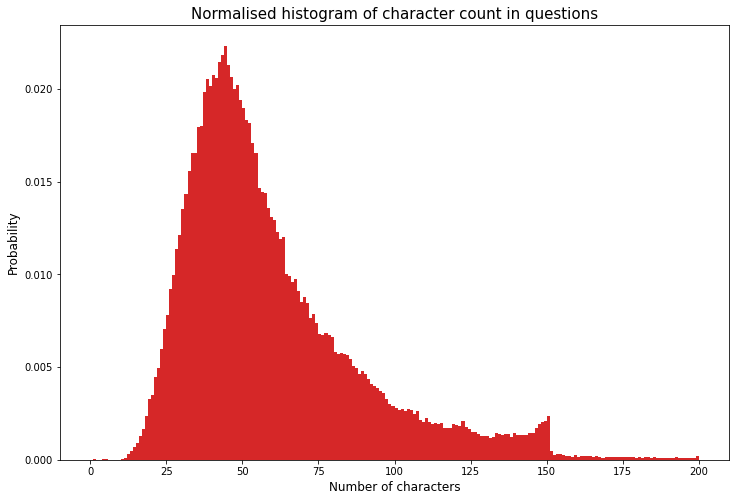

In [16]:
plt.figure(figsize=(12, 8))
plt.hist(cc_train, bins=200, range=[0, 200], color="tab:red", density=True)
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.xlabel('Number of characters', fontsize=12)
plt.ylabel('Probability', fontsize=12)

In [29]:
print(min(cc_train), max(cc_train))

0 1169


In [17]:
len_tok = qs_tr.apply(lambda x: len((tokenizer.tokenize(x))))

284


Text(0, 0.5, 'Probability')

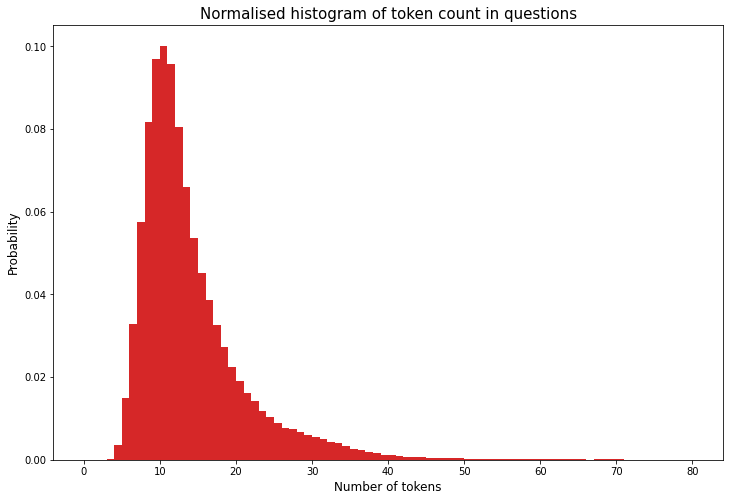

In [18]:
plt.figure(figsize=(12, 8))
plt.hist(len_tok, bins=80, range=[0, 80], color="tab:red", density=True)
plt.title('Normalised histogram of token count in questions', fontsize=15)
plt.xlabel('Number of tokens', fontsize=12)
plt.ylabel('Probability', fontsize=12)

In [31]:
print(min(len_tok), max(len_tok))

0 284


In [19]:
diff = [0]*284
for i in range(n_train):
    diff[abs(len_tok[i] - len_tok[i + n_train])] += 1

In [22]:
diff[:10]

[57022, 81434, 61180, 44257, 31449, 23597, 17899, 13936, 11125, 9188]

In [115]:
pos = 0
for i in range(len(diff)):
    if diff[i] >= 10:
        pos = i
print(pos)

62


Text(0.5, 1.0, 'Log-histogram of differences in pairs')

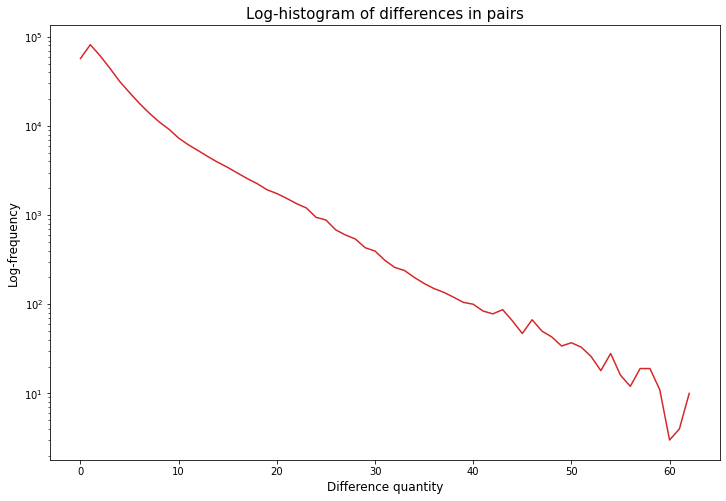

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(range(63),diff[:63], color="tab:red")
plt.yscale("log")
plt.xlabel("Difference quantity", fontsize=12)
plt.ylabel("Log-frequency", fontsize=12)
plt.title("Log-histogram of differences in pairs", fontsize=15)

## **Word study**

https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb

In [53]:
chs = [".", ":", ",", ";", "¿", "?", "¡", "!", "(", ")", "'", '"']

In [55]:
prova = ["h.erers r,fa'sf (d\"fsa) ;i,:o", "h.erers r,'fasf (dfsa) ;i,:o"]
for i in range(len(prova)):
    for ch in chs:
        prova[i] = prova[i].replace(ch, "")
print(prova)

['herers rfasf dfsa io', 'herers rfasf dfsa io']


In [54]:
QS_TR = qs_tr.copy()
words = {}
for s in range(len(QS_TR)):
    for ch in chs:
        QS_TR[s] = QS_TR[s].replace(ch, "")
    for w in QS_TR[s].split(' '):
        words[w] = words.get(w,0) + 1

In [64]:
print(len(words))
sorted(words.items(), key=lambda item: item[1], reverse=True)[:10]

141527


[('the', 372316),
 ('What', 292887),
 ('is', 216832),
 ('I', 212601),
 ('a', 208748),
 ('to', 204709),
 ('How', 202001),
 ('in', 191594),
 ('of', 159425),
 ('do', 145554)]

In [33]:
wc_train = qs_tr.apply(lambda x: len(x.split(' ')))

Text(0, 0.5, 'Probability')

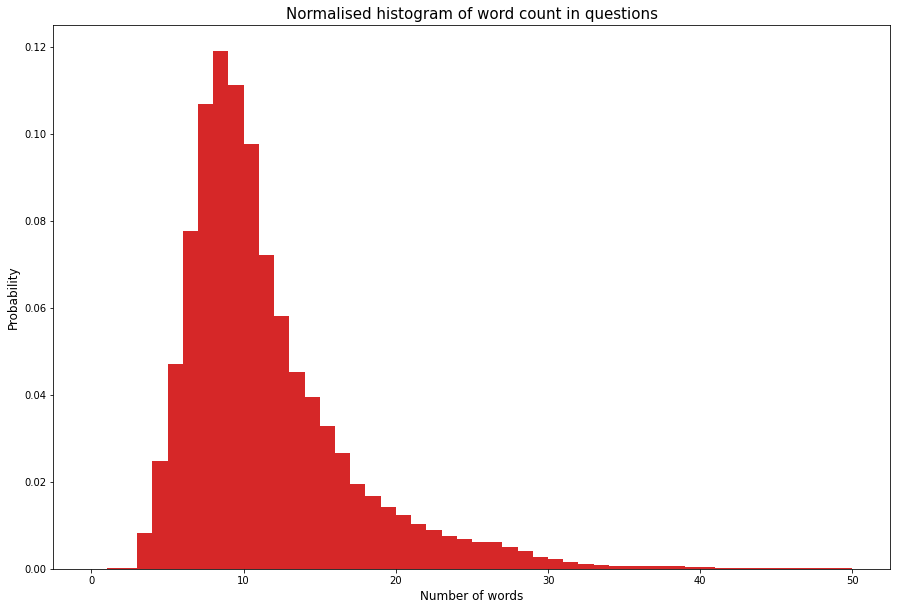

In [26]:
plt.figure(figsize=(15, 10))
plt.hist(wc_train, bins=50, range=[0, 50], color="tab:red", density=True)
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.xlabel('Number of words', fontsize=12)
plt.ylabel('Probability', fontsize=12)

In [32]:
print(min(wc_train), max(wc_train))

1 237


### **Word Cloud:**

https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb

(-0.5, 1439.5, 1079.5, -0.5)

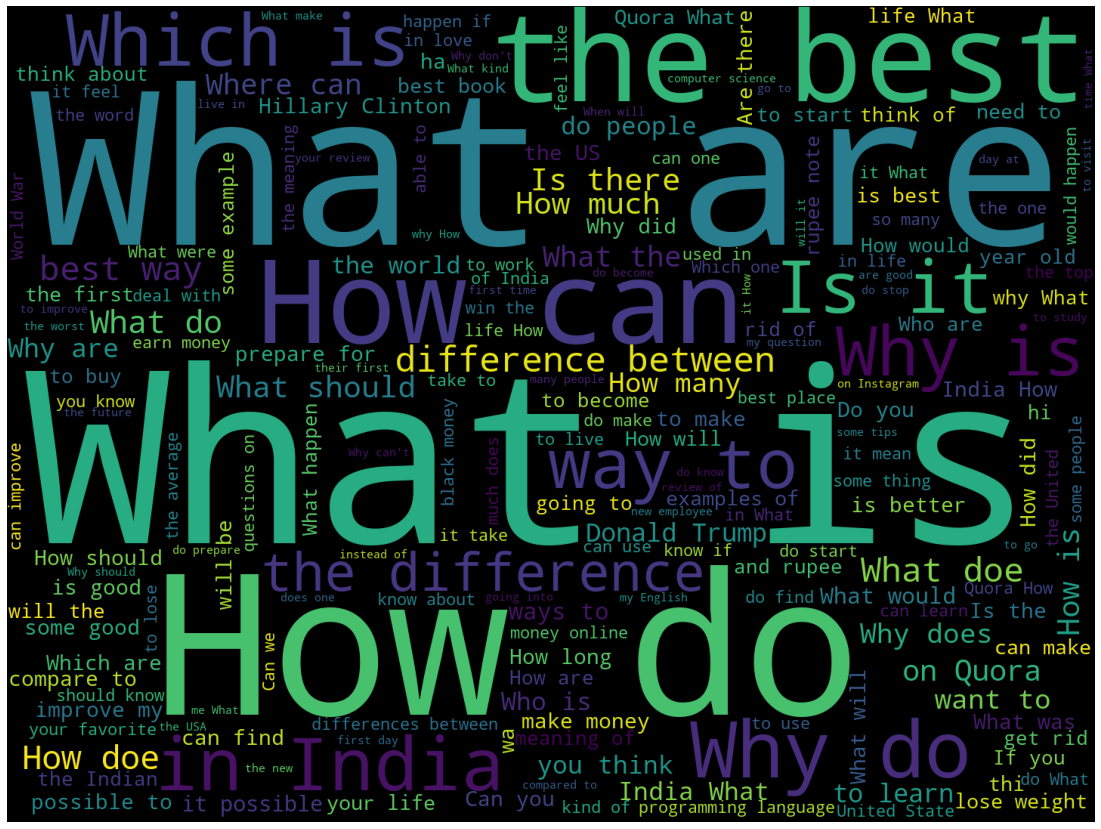

In [101]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(qs_tr.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

## **Semantic study**

In [ ]:
qmarks = np.mean(qs_tr.apply(lambda x: '?' in x))
math = np.mean(qs_tr.apply(lambda x: '[math]' in x))
fullstop = np.mean(qs_tr.apply(lambda x: '.' in x))
capital_first = np.mean(qs_tr.apply(lambda x: x[0].isupper()))
capitals = np.mean(qs_tr.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(qs_tr.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

## Example for presentation

In [6]:
def truncate(tokens_a, tokens_b, max_seq_length):
    '''
    Truncates by max_seq_length the concatenation of the two sentences
    '''
    len_a = len(tokens_a);  len_b = len(tokens_b)
    len_t = len_a + len_b
    m = min(1,max_seq_length/len_t)
    if len_a < len_b:
        return tokens_a[:int(np.ceil(len_a*m))], tokens_b[:int(np.floor(len_b*m))]
    else:
        return tokens_a[:int(np.floor(len_a*m))], tokens_b[:int(np.ceil(len_b*m))]
    

tokA = token_exploration("Did Ben Affleck shine more than Christian Bale as Batman?")
tokB = token_exploration("No fanboys please, but who was the true batman, Christian Bale or Ben Affleck?")
truncate(tokA, tokB, 28-3)

Did Ben Affleck shine more than Christian Bale as Batman?    ['did', 'ben', 'af', '##fle', '##ck', 'shine', 'more', 'than', 'christian', 'bal', '##e', 'as', 'batman', '?']    [2106, 3841, 21358, 21031, 3600, 12342, 2062, 2084, 3017, 28352, 2063, 2004, 8942, 1029] ,  mida: 14
No fanboys please, but who was the true batman, Christian Bale or Ben Affleck?    ['no', 'fan', '##boys', 'please', ',', 'but', 'who', 'was', 'the', 'true', 'batman', ',', 'christian', 'bal', '##e', 'or', 'ben', 'af', '##fle', '##ck', '?']    [2053, 5470, 24916, 3531, 1010, 2021, 2040, 2001, 1996, 2995, 8942, 1010, 3017, 28352, 2063, 2030, 3841, 21358, 21031, 3600, 1029] ,  mida: 21


([2106, 3841, 21358, 21031, 3600, 12342, 2062, 2084, 3017, 28352],
 [2053,
  5470,
  24916,
  3531,
  1010,
  2021,
  2040,
  2001,
  1996,
  2995,
  8942,
  1010,
  3017,
  28352,
  2063])